# 📈 Portfolio Optimisation (Sharpe Ratio)

- **Objective**: Maximise return for a given level of risk or minimise risk for a given return.
- **Uses**: Expected returns, variances, and covariances.
- **Output**: The efficient frontier — a set of optimal portfolios.
- **Focus**: Balances return vs risk, not necessarily in a single number.

## Dependencies

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

from scipy.optimize import minimize
from datetime import datetime, timedelta
from typing import Final

## Ticker Data

In [2]:
END_DATE = datetime.today()
DAYS_IN_A_YEAR = 365
NUMBER_OF_YEARS = 5
START_DATE = END_DATE - timedelta(days = NUMBER_OF_YEARS * DAYS_IN_A_YEAR)

TICKERS: Final[list[str]] = ['SPY','BND','GLD','QQQ','VTI']

# adjusted close price is better for portfolio optimisation as it is more accurate including dividends and stock splits
adj_close_df = pd.DataFrame()
for ticker in TICKERS:
    data = yf.download(ticker, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
    adj_close_df[ticker] = data["Close"]

adj_close_df.head()

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2020-09-16,315.481476,76.299950,183.970001,266.658600,160.042709
2020-09-17,312.706757,76.299950,182.960007,262.492828,158.722763
2020-09-18,309.106598,76.213676,183.199997,259.142761,157.179688
2020-09-21,305.666443,76.256844,179.520004,259.764160,155.283371
2020-09-22,308.779449,76.282700,178.649994,264.590240,156.826447


## Lognormal Returns

In [3]:
# Log returns make multi-period calculations additive, are more symmetric, better match statistical assumptions, and represent continuous compounding.
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

## Covariance Matrix

In [4]:
TRADING_DAYS_IN_A_YEAR = 252

cov_matrix = log_returns.cov() * TRADING_DAYS_IN_A_YEAR
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,0.030061,0.001937,0.003372,0.037413,0.030549
BND,0.001937,0.003603,0.003131,0.002744,0.002036
GLD,0.003372,0.003131,0.022792,0.004271,0.003532
QQQ,0.037413,0.002744,0.004271,0.052736,0.038090
VTI,0.030549,0.002036,0.003532,0.038090,0.031373


## Calculate Portfolio Perfomance Metrics

In [6]:
def standard_deviation(weights: np.ndarray, cov_matrix: pd.DataFrame) -> float:
    """
    Computes the annualized volatility of a portfolio given its asset weights and the covariance matrix of returns. 
    Use this to measure the total risk of the portfolio.
    """
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights: np.ndarray, log_returns: pd.DataFrame) -> float:
    """
    Calculates the annualized expected return of a portfolio based on historical log returns and asset weights. 
    Use this to estimate how much the portfolio is likely to earn.
    """
    return np.sum(log_returns.mean() * weights) * TRADING_DAYS_IN_A_YEAR

def sharpe_ratio(weights: np.ndarray, log_returns: pd.DataFrame, cov_matrix: pd.DataFrame, risk_free_rate: float) -> float:
    """
    Computes the Sharpe Ratio of a portfolio, which measures the risk-adjusted return. 
    A higher Sharpe Ratio indicates better return per unit of risk.
    """
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

## Risk Free Rate with FRED API

In [8]:
import os

from dotenv import load_dotenv
from fredapi import Fred

# Load .env file
load_dotenv()

FRED_API_KEY = os.getenv("FRED_API_KEY")

fred = Fred(api_key=FRED_API_KEY)
ten_year_treasury_rate = fred.get_series_latest_release("GS10") / 100

risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(f"Risk free rate: {risk_free_rate}")

Risk free rate: 0.0426


## Optimise Portfolio

In [22]:
def neg_sharpe_ratio(weights: np.ndarray, log_returns: pd.DataFrame, cov_matrix: pd.DataFrame, risk_free_rate: float) -> float:
    """
    negative sharpe ratio
    """
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

LOWER_BOUND = 0 # Cannot go short
UPPER_BOUND = 0.4 # Cannot have any security with more than 50% weighting
bounds = [(LOWER_BOUND, UPPER_BOUND) for _ in range(len(TICKERS))]

initial_weights = np.array([1/len(TICKERS)]*len(TICKERS)) # start with equal weighting

# optimise the weights to maximise the sharp ratio
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimal_weights = optimized_results.x

In [23]:
print("Optimal Weights:")
for ticker, weight in zip(TICKERS, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.4000
BND: 0.0000
GLD: 0.4000
QQQ: 0.0000
VTI: 0.2000
Expected Annual Return: 0.1358
Expected Volatility: 0.1275
Sharpe Ratio: 0.7312


## Display Portfolio

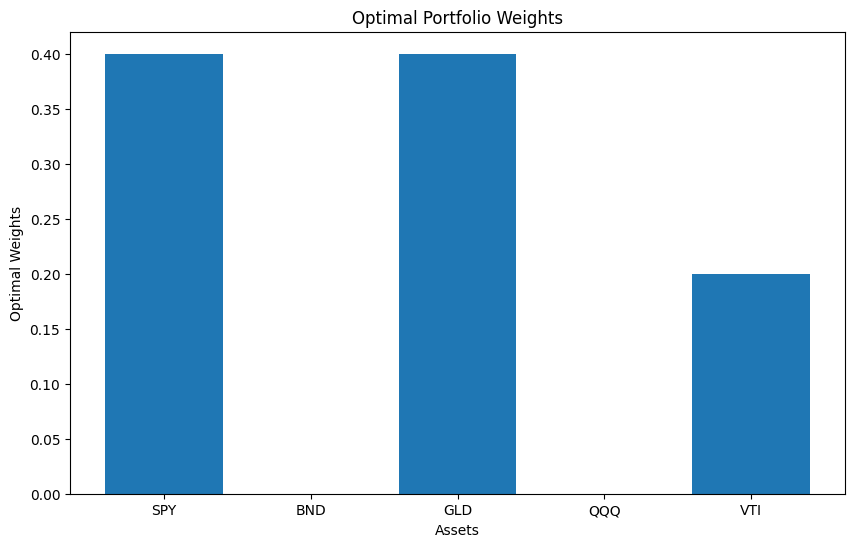

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(TICKERS, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()